# 03 — Data Loading and Preprocessing

This notebook loads the cleaned TED dataset and applies additional preprocessing to prepare the data for modeling and analysis.

Focus areas include:
- Text normalization (lowercasing, punctuation removal, lemmatization)
- Feature extraction (word/sentence/char count, readability)
- Visualizing linguistic structures
- Saving a preprocessed dataset for modeling

In [12]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import textstat

sys.path.append(os.path.abspath('.'))
from utils.setup import init_environment
init_environment()

Environment initialized.


Shape: (4095, 13)


,key_column,speaker_occupation,speaker,transcript,event,description,title,recorded_date,views,duration,url,tags,completeness_score
0,https://www.ted.com/talks/maira_kalman_the_ill...,"Illustrator, author",Maira Kalman,What I am always thinking about is what this s...,TED2007,Author and illustrator Maira Kalman talks abou...,The illustrated woman,2007-03-03,815011,1050,https://www.ted.com/talks/maira_kalman_the_ill...,"['art', 'children', 'culture', 'design', 'ente...",100.0
1,https://www.ted.com/talks/virginia_postrel_on_...,Journalist,Virginia Postrel,You might be wondering why I'm wearing sunglas...,TED2004,"In a timely talk, cultural critic Virginia Pos...",On glamour,2004-02-02,424070,975,https://www.ted.com/talks/virginia_postrel_on_...,"['beauty', 'business', 'culture', 'entertainme...",100.0
2,https://www.ted.com/talks/robert_wright_the_ev...,"Journalist, philosopher",Robert Wright,I'm going to talk about compassion and the gol...,TEDSalon 2009 Compassion,Robert Wright uses evolutionary biology and ga...,The evolution of compassion,2009-10-14,298774,1016,https://www.ted.com/talks/robert_wright_the_ev...,"['charter for compassion', 'compassion', 'evol...",100.0
3,https://www.ted.com/talks/dennis_vanengelsdorp...,Bee expert,Dennis vanEngelsdorp,"What I'd like you to do is, just really quickl...",Taste3 2008,Bees are dying in droves. Why? Leading apiaris...,A plea for bees,2008-07-19,765570,988,https://www.ted.com/talks/dennis_vanengelsdorp...,"['animals', 'bees', 'disease', 'food', 'insect...",100.0
4,https://www.ted.com/talks/barry_schuler_genomi...,Entrepreneur,Barry Schuler,"What's happening in genomics, and how this rev...",Taste3 2008,What is genomics? How will it affect our lives...,Genomics 101,2008-06-30,458222,1286,https://www.ted.com/talks/barry_schuler_genomi...,"['biology', 'entrepreneur', 'food', 'genetics'...",100.0


## Dataset Overview

We begin by inspecting the structure and completeness of the dataset. Key content columns include the transcript, speaker metadata, tags, and engagement metrics (views).

This step confirms readiness for preprocessing and highlights potential cleaning needs.


In [31]:
# Structure + Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4095 entries, 0 to 4094
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key_column          4095 non-null   object 
 1   speaker_occupation  4095 non-null   object 
 2   speaker             4095 non-null   object 
 3   transcript          4095 non-null   object 
 4   event               4095 non-null   object 
 5   description         4095 non-null   object 
 6   title               4095 non-null   object 
 7   recorded_date       4095 non-null   object 
 8   views               4095 non-null   int64  
 9   duration            4095 non-null   int64  
 10  url                 4095 non-null   object 
 11  tags                4095 non-null   object 
 12  completeness_score  4095 non-null   float64
dtypes: float64(1), int64(2), object(10)
memory usage: 416.0+ KB


### Structure & Completeness Check

All 13 columns are present and fully populated — no missing values to handle.  
Data types are appropriate for further analysis and feature engineering.

- `transcript`, `tags`, `speaker` and `event` are ready for text processing
- `views` and `duration` are numeric and suitable for modeling
- `recorded_date` may be converted to datetime if we later explore trends over time

In [34]:
# Column Summary Table
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key_column,4095,4095,https://www.ted.com/talks/maira_kalman_the_ill...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speaker_occupation,4095,2033,Unknown,548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speaker,4095,3377,Alex Gendler,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transcript,4095,4083,I learned about the Haiti earthquake by Skype....,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event,4095,471,TED-Ed,585,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,4095,4087,Sir Ken Robinson outlines 3 principles crucial...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,4095,4087,How to escape education's death valley,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recorded_date,4095,1378,2017-04-24,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
views,4095.0,NaN,NaN,NaN,2187595.272039,3590482.784913,6829.0,887358.0,1387473.0,2156902.5,65678748.0
duration,4095.0,NaN,NaN,NaN,725.575336,369.348435,60.0,391.0,737.0,973.0,3991.0



### Summary of Key Findings

**Categorical/Text Columns:**

| Column              | Notes                                                    |
|---------------------|----------------------------------------------------------|
| `speaker_occupation`| 2,033 unique values — very diverse roles (many unknowns) |
| `speaker`           | 3,377 unique — most speakers appear only once            |
| `title`, `description`, `transcript` | Near 1:1 uniqueness — perfect for NLP             |
| `event`             | 471 unique — TED-Ed appears most (585 times)             |
| `tags`              | 4,060 unique — good diversity in topic labeling          |
| `recorded_date`     | 1,378 unique dates — date analysis is possible if needed |

**Numeric Columns:**

| Column              | Min → Max              | Comment                                     |
|---------------------|------------------------|---------------------------------------------|
| `views`             | 6,829 → 65,678,748     | Highly skewed — some talks are viral outliers |
| `duration`          | 60 sec → 3,991 sec     | Wide range — from ~1 min to over 1 hour     |
| `completeness_score`| Always 100%            | Good — no filtering needed here             |



### Column Summary Insights

- **Speaker and event diversity**: Over 3,000 speakers and 400+ unique events are represented, showing wide topical coverage.
- **Views** are highly skewed — some talks are exceptionally popular.
- **Tags** and **titles** are nearly unique, confirming that each entry is a distinct talk.
- **Transcript**, `description`, and `title` fields are well-populated and ready for NLP feature extraction.

## Missingness and Column Overview

We now generate a detailed summary of each column, including:

- Total and percentage of missing values
- Number of unique entries (categorical diversity)
- Data type for modeling readiness

In [48]:
# Missing & Type Overview
summary_df = pd.DataFrame({
    "Column": df.columns,
    "Non-Null Count": df.notnull().sum(),
    "Missing Count": df.isnull().sum(),
    "Missing %": df.isnull().mean() * 100,
    "Unique Values": df.nunique(),
    "Data Type": df.dtypes.values
}).sort_values("Missing %", ascending=False)

summary_df.style.bar(subset=["Missing %"], color='lightcoral').format({"Missing %": "{:.2f}%"})


/opt/anaconda3/lib/python3.12/site-packages/pandas/io/formats/style.py:4040: RuntimeWarning: invalid value encountered in scalar divide
  end = (x - left) / (right - left)


,Column,Non-Null Count,Missing Count,Missing %,Unique Values,Data Type
key_column,key_column,4095,0,0.00%,4095,object
speaker_occupation,speaker_occupation,4095,0,0.00%,2033,object
speaker,speaker,4095,0,0.00%,3377,object
transcript,transcript,4095,0,0.00%,4083,object
event,event,4095,0,0.00%,471,object
description,description,4095,0,0.00%,4087,object
title,title,4095,0,0.00%,4087,object
recorded_date,recorded_date,4095,0,0.00%,1378,object
views,views,4095,0,0.00%,4092,int64
duration,duration,4095,0,0.00%,1196,int64


### Column Quality Overview

All 14 columns (including `transcript_clean`) are fully populated — no missing values were found.

Key observations:
- `views` and `duration` are numeric with high cardinality — ideal for regression or correlation analysis
- Categorical fields like `speaker`, `title`, and `event` show strong diversity:
  - 3,377 unique speakers
  - 471 unique events
  - 4,060 unique tag sets
- `transcript` and `description` are nearly unique, which is appropriate for content-based modeling
- `completeness_score` is always 100%, confirming that earlier cleaning was successful

These columns are well-suited for NLP processing and supervised learning tasks.


## Transcript Preprocessing

We clean the `transcript` column to prepare it for feature extraction. This includes:

- Lowercasing all text
- Removing punctuation
- Removing special bracketed markers like `[Laughter]`, `[Music]`


In [52]:
# Normalize the Transcript Text

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"\[.*?\]", "", text)  # remove things like [Laughter]
    text = re.sub(r"\s+", " ", text)     # remove extra whitespace
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    return text.strip()

# Apply the cleaning function
df["transcript_clean"] = df["transcript"].apply(clean_text)

In [54]:
# confirm with random rows
df[["transcript", "transcript_clean"]].sample(3, random_state=42)

,transcript,transcript_clean
1298,Imagine that you invented a device that can re...,imagine that you invented a device that can re...
2711,Nicolas Steno is rarely heard of outside Intro...,nicolas steno is rarely heard of outside intro...
3543,"During World War I, one of the horrors of tren...",during world war i one of the horrors of trenc...


In [56]:
# how many were modified
(df["transcript"] != df["transcript_clean"]).sum()

4095

## Basic Linguistic Feature Extraction

We now derive structural metrics from the cleaned transcript:
- **Word count** — total words per talk
- **Character count** — total characters per talk
- **Sentence count** — number of sentences (based on original, not cleaned text)


In [60]:
# Word and character count from cleaned transcript
df["word_count"] = df["transcript_clean"].apply(lambda x: len(x.split()))
df["char_count"] = df["transcript_clean"].apply(len)

# Sentence count from original transcript using NLTK
import nltk
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

df["sentence_count"] = df["transcript"].apply(lambda x: len(sent_tokenize(x)) if pd.notnull(x) else 0)


[nltk_data] Downloading package punkt to /Users/favrholdt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Review the Distribution of These Features

In [63]:
df[["word_count", "char_count", "sentence_count"]].describe()


,word_count,char_count,sentence_count
count,4095.00000,4095.000000,4095.000000
mean,1768.20464,9603.052015,96.541636
std,950.09473,5033.296723,57.628717
min,89.00000,474.000000,1.000000
25%,914.50000,4975.000000,49.000000
50%,1729.00000,9441.000000,89.000000
75%,2406.50000,13054.500000,129.000000
max,6059.00000,31877.000000,465.000000


### Structural Summary

- The average TED Talk in this dataset contains **~1,768 words** across **~97 sentences**
- Sentence counts vary significantly, with some talks having over 400 — these may be long-form or split improperly
- The shortest valid talks (89 words, 1 sentence) are retained but could be flagged in downstream modeling
- These metrics will be useful for readability analysis and for modeling content complexity


### Interpretation of Structural Features

| Feature         | Insights                                                                 |
|-----------------|--------------------------------------------------------------------------|
| `word_count`     | Avg: ~1,768 words per talk  <br> Shortest: 89 words  <br> Longest: 6,059 words  <br> Majority range: ~900–2,400 words (IQR)  <br> Reflects a typical TED Talk length of 5–18 minutes |
| `char_count`     | Highly correlated with word count  <br> Avg: ~9,600 characters  <br> Upper bound over 31,000 → some very long talks  <br> Useful for modeling verbosity |
| `sentence_count` | Avg: ~97 sentences per talk  <br> Range: 1 to 465  <br> Many talks fall between 49 and 129  <br> Gives a structural unit for sentence-level analysis |


## Distribution of Structural Features

We now visualize the distributions of:

- Word count
- Sentence count
- Character count

These plots help identify outliers, typical ranges, and whether data transformations might be needed for modeling (e.g., log scaling).


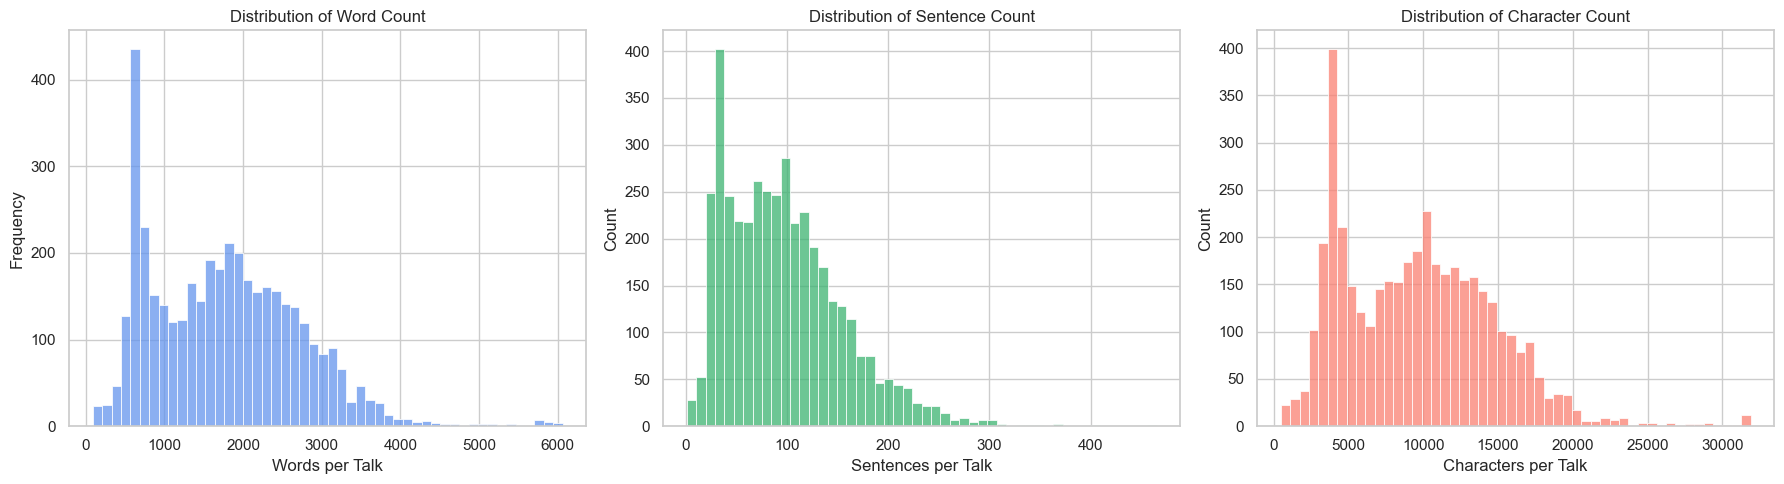

In [74]:
# Set up 3 histograms side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df["word_count"], bins=50, ax=axes[0], color="cornflowerblue")
axes[0].set_title("Distribution of Word Count")
axes[0].set_xlabel("Words per Talk")
axes[0].set_ylabel("Frequency")

sns.histplot(df["sentence_count"], bins=50, ax=axes[1], color="mediumseagreen")
axes[1].set_title("Distribution of Sentence Count")
axes[1].set_xlabel("Sentences per Talk")

sns.histplot(df["char_count"], bins=50, ax=axes[2], color="salmon")
axes[2].set_title("Distribution of Character Count")
axes[2].set_xlabel("Characters per Talk")

plt.tight_layout()
plt.savefig("../plots/structure_distributions.png")
plt.show()


### Structural Feature Distributions

- **Word Count**: Most talks cluster between 800 and 2,500 words, with a spike around ~500–600 words. A few outliers exceed 4,000 words.
- **Sentence Count**: Peaks around 80–120 sentences, with some very short talks (under 20) and long ones (300+).
- **Character Count**: Closely mirrors word count distribution, peaking around 4,500–13,000 characters.

These plots confirm that while most TED Talks follow a common structural range, there are notable outliers on both the short and long end that could impact modeling.


## Advanced Linguistic Feature Extraction

We compute additional text-based features to better capture the style and structure of each talk:

- **Average word length** — indicates vocabulary complexity
- **Average sentence length** — words per sentence
- **Lexical diversity** — proportion of unique words used


In [81]:
# Avg word length (based on cleaned transcript)
df["avg_word_length"] = df["transcript_clean"].apply(lambda x: np.mean([len(w) for w in x.split()]) if x else 0)

# Avg sentence length (words per sentence)
df["avg_sentence_length"] = df.apply(
    lambda row: row["word_count"] / row["sentence_count"] if row["sentence_count"] > 0 else 0, axis=1
)

# Lexical diversity = unique words / total words
df["lexical_diversity"] = df["transcript_clean"].apply(
    lambda x: len(set(x.split())) / len(x.split()) if x and len(x.split()) > 0 else 0
)

In [83]:
df[["avg_word_length", "avg_sentence_length", "lexical_diversity"]].describe()

,avg_word_length,avg_sentence_length,lexical_diversity
count,4095.000000,4095.000000,4095.000000
mean,4.482151,20.022403,0.363028
std,0.301962,14.634656,0.090531
min,3.069182,6.253333,0.172473
25%,4.284521,16.128054,0.294706
50%,4.448512,18.888060,0.345655
75%,4.631012,22.057479,0.416489
max,6.348416,586.000000,0.811881


In [87]:
df[["transcript_clean", "avg_word_length", "avg_sentence_length", "lexical_diversity"]].head()

,transcript_clean,avg_word_length,avg_sentence_length,lexical_diversity
0,what i am always thinking about is what this s...,3.988685,16.943005,0.262997
1,you might be wondering why im wearing sunglass...,4.448681,15.943182,0.282609
2,im going to talk about compassion and the gold...,4.505267,21.507812,0.250636
3,what id like you to do is just really quickly ...,4.240342,20.744681,0.265299
4,whats happening in genomics and how this revol...,4.319369,19.963636,0.251973


### Advanced Linguistic Feature Insights

- **Average Word Length**
  - Mean: ~4.48 characters per word
  - Range: 3.07 to 6.35
  - Most talks use relatively short, accessible words (good for general audiences)

- **Average Sentence Length (words per sentence)**
  - Mean: ~20 words per sentence
  - Range: 6 to 586
  - A few outliers use very long sentences; most are in the 16–22 word range

- **Lexical Diversity (unique words / total words)**
  - Mean: ~0.36
  - Indicates that, on average, about 36% of the words in a talk are unique
  - Range from 0.17 to 0.81 — high variation across speakers and styles

These features will help the model distinguish between simple and complex speech patterns, as well as between repetitive and diverse vocabularies.


## Visualization of Advanced Linguistic Features

We now plot the distributions of:

- Average word length
- Average sentence length
- Lexical diversity

Then, we explore relationships between these features using scatter plots.


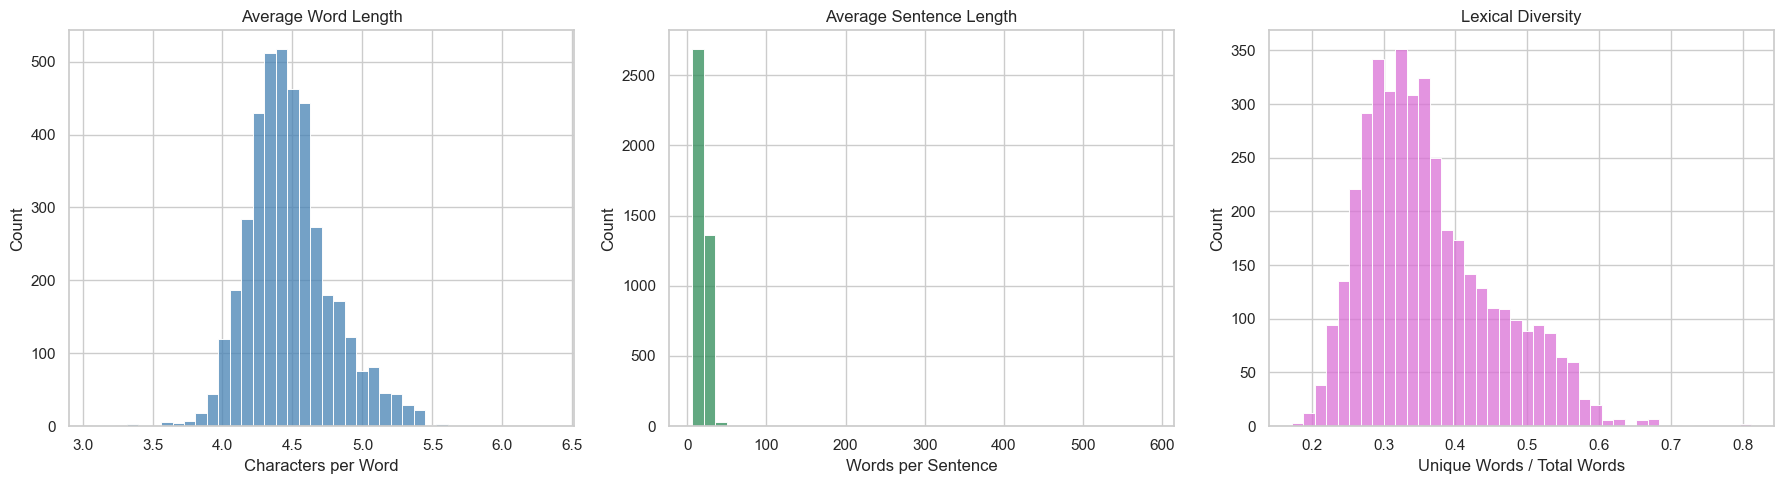

In [92]:
# Histograms of advanced linguistic features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df["avg_word_length"], bins=40, ax=axes[0], color="steelblue")
axes[0].set_title("Average Word Length")
axes[0].set_xlabel("Characters per Word")

sns.histplot(df["avg_sentence_length"], bins=40, ax=axes[1], color="seagreen")
axes[1].set_title("Average Sentence Length")
axes[1].set_xlabel("Words per Sentence")

sns.histplot(df["lexical_diversity"], bins=40, ax=axes[2], color="orchid")
axes[2].set_title("Lexical Diversity")
axes[2].set_xlabel("Unique Words / Total Words")

plt.tight_layout()
plt.savefig("../plots/linguistic_feature_distributions.png")
plt.show()


### Distribution Insights (Advanced Linguistic Features)

- **Average Word Length**: Most talks fall between 4.0 and 4.8 characters per word, indicating generally accessible vocabulary.
- **Average Sentence Length**: Heavily skewed right, with the majority of talks averaging 15–25 words per sentence. A few outliers exceed 100+ words, which may indicate transcription artifacts or extreme verbosity.
- **Lexical Diversity**: Most values fall between 0.3 and 0.45, with a long tail toward both lower and higher diversity. Talks with lower values likely repeat terminology or use simpler language.


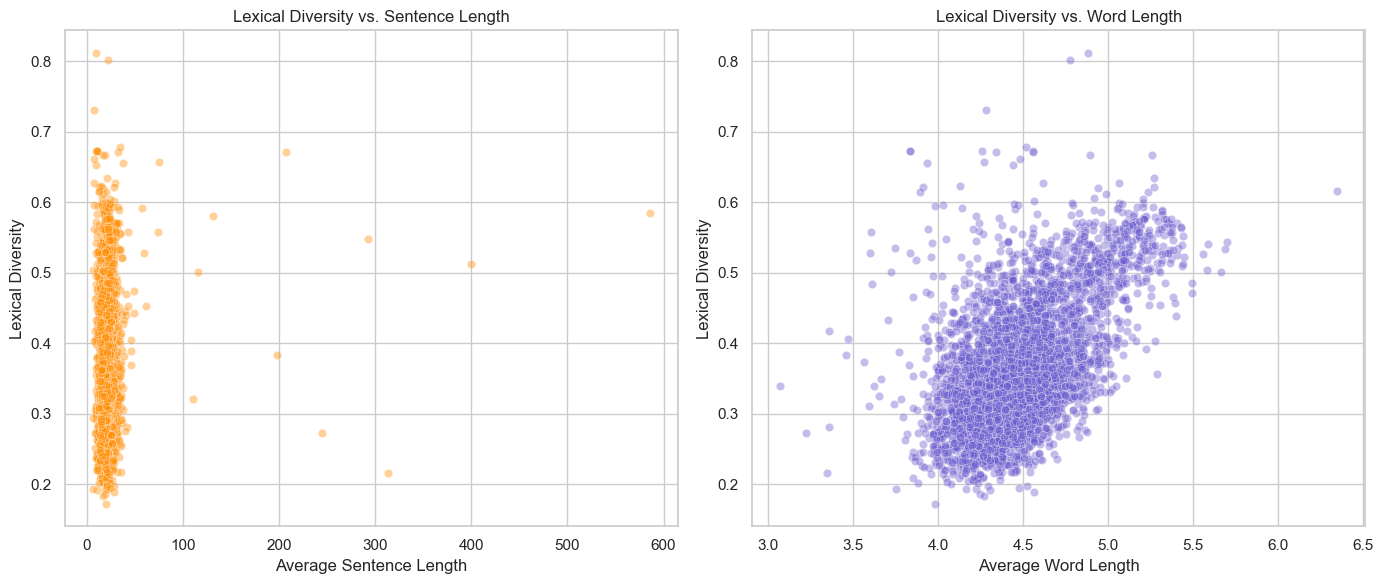

In [94]:
# Scatter plots to show relationships between features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Lexical Diversity vs. Average Sentence Length
sns.scatterplot(
    data=df, x="avg_sentence_length", y="lexical_diversity",
    alpha=0.4, ax=axes[0], color="darkorange"
)
axes[0].set_title("Lexical Diversity vs. Sentence Length")
axes[0].set_xlabel("Average Sentence Length")
axes[0].set_ylabel("Lexical Diversity")

# Word Length vs. Lexical Diversity
sns.scatterplot(
    data=df, x="avg_word_length", y="lexical_diversity",
    alpha=0.4, ax=axes[1], color="slateblue"
)
axes[1].set_title("Lexical Diversity vs. Word Length")
axes[1].set_xlabel("Average Word Length")
axes[1].set_ylabel("Lexical Diversity")

plt.tight_layout()
plt.savefig("../plots/linguistic_feature_scatterplots.png")
plt.show()


### Scatter Plot Observations

- **Lexical Diversity vs. Average Sentence Length**:
  - Most talks are tightly clustered below 60 words per sentence
  - No strong linear relationship, but extreme sentence lengths seem to reduce diversity

- **Lexical Diversity vs. Word Length**:
  - Moderate positive trend: talks with longer average words tend to use a more diverse vocabulary
  - Suggests that lexical richness grows with more complex vocabulary

These insights can inform feature selection for modeling and support hypotheses about what makes TED Talks more "linguistically engaging."


In [101]:
import textstat

## Readability Metrics

We now calculate two key readability scores:

- **Flesch Reading Ease**: Higher scores = easier to read (scale: 0–100)
- **Flesch-Kincaid Grade Level**: U.S. school grade level needed to comprehend (e.g., 8.0 = 8th grade)

These metrics quantify how accessible the content is to general audiences.


In [105]:
# Calculate readability scores from original transcript
df["flesch_reading_ease"] = df["transcript"].apply(lambda x: textstat.flesch_reading_ease(x))
df["flesch_kincaid_grade"] = df["transcript"].apply(lambda x: textstat.flesch_kincaid_grade(x))

In [106]:
df[["flesch_reading_ease", "flesch_kincaid_grade"]].describe()

,flesch_reading_ease,flesch_kincaid_grade
count,4095.000000,4095.000000
mean,64.553421,8.508522
std,12.438547,3.567196
min,-344.677000,1.210098
25%,58.894661,7.005819
50%,65.503122,8.271385
75%,71.552621,9.653528
max,99.844052,160.706000


### Readability Score Summary

- **Flesch Reading Ease**
  - Mean: 64.6 → Considered readable for most audiences
  - 25th to 75th percentile: ~59 to 72
  - Talks scoring below 50 may be more complex or academic

- **Flesch-Kincaid Grade**
  - Median grade level: ~8.3
  - Range: 1.2 to 160 → extremely high values are likely artifacts (e.g., long unpunctuated sentences)
  - Most TED Talks fall within a 7th–10th grade readability range

These metrics help quantify language accessibility — critical for feedback and model explainability in the Streamlit app.


In [110]:
# Save processed dataset to disk
df.to_csv("../data/preprocessed_data.csv", index=False)
print("Preprocessed data saved to: ../data/preprocessed_data.csv")


Preprocessed data saved to: ../data/preprocessed_data.csv


In [112]:
from utils.save_tools import save_notebook_and_summary

save_notebook_and_summary(
    notebook_name="03_data_loading_and_preprocessing",
    summary={
        "description": "Loaded cleaned TED dataset, applied text normalization, extracted structural and advanced linguistic features, computed readability scores, and saved preprocessed output.",
        "records_processed": int(df.shape[0]),
        "columns_added": [
            "transcript_clean",
            "word_count", "char_count", "sentence_count",
            "avg_word_length", "avg_sentence_length", "lexical_diversity",
            "flesch_reading_ease", "flesch_kincaid_grade"
        ],
        "output_file": "../data/preprocessed_data.csv",
        "plots_generated": [
            "../plots/structure_distributions.png",
            "../plots/linguistic_feature_distributions.png",
            "../plots/linguistic_feature_scatterplots.png"
        ]
    }
)


<IPython.core.display.Javascript object>

Notebook save triggered.
Summary saved to: ../reports/03_data_loading_and_preprocessing_summary_2025-05-26_04-42-48.json


------------------------

In [ ]:
### Missing Values Summary

This dataset has no missing values in any column. No imputation or filling is required.

In [ ]:
### Advanced Cleaning with Stopword Removal and Lemmatization

In [ ]:
# Stopword Removal + Lemmatization
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_clean(text):
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

df["word_count_original"] = df["transcript_clean"].apply(lambda x: len(x.split()))
df["transcript_clean"] = df["transcript_clean"].apply(advanced_clean)
df["word_count"] = df["transcript_clean"].apply(lambda x: len(x.split()))


In [ ]:
## 3. Extract Text Features

In [ ]:
# Character Count
df["char_count"] = df["transcript_clean"].apply(len)


In [ ]:
#Sentence Count
nltk.download("punkt")
from nltk.tokenize import sent_tokenize

df["sentence_count"] = df["transcript"].apply(lambda x: len(sent_tokenize(x)) if pd.notnull(x) else 0)


In [ ]:
## 4. Readability Metrics


In [ ]:
#Readability Calculations
df["avg_sentence_length"] = df["word_count"] / df["sentence_count"].replace(0, np.nan)
df["avg_word_length"] = df["char_count"] / df["word_count"].replace(0, np.nan)
df["flesch_score"] = 206.835 - (1.015 * df["avg_sentence_length"]) - (84.6 * df["avg_word_length"])
df["flesch_kincaid_grade"] = (0.39 * df["avg_sentence_length"]) + (11.8 * df["avg_word_length"]) - 15.59


In [ ]:
## 5. Word Count Comparison Before vs. After Cleaning


In [ ]:
# Word Count Comparison Plot
plt.figure(figsize=(10, 5))
sns.histplot(df["word_count_original"], label="Original", color="gray", bins=50, kde=True)
sns.histplot(df["word_count"], label="After Lemmatization", color="cornflowerblue", bins=50, kde=True)
plt.title("Transcript Word Count: Original vs. Cleaned")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("../plots/wordcount_comparison.png")
plt.show()


In [ ]:
## 6. Visualize Linguistic Distributions


In [ ]:
# Histograms

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df["sentence_count"], bins=50, ax=axes[0, 0], color="skyblue")
axes[0, 0].set_title("Sentence Count")

sns.histplot(df["avg_sentence_length"].dropna(), bins=50, ax=axes[0, 1], color="salmon")
axes[0, 1].set_title("Average Sentence Length")

sns.histplot(df["avg_word_length"].dropna(), bins=50, ax=axes[1, 0], color="lightgreen")
axes[1, 0].set_title("Average Word Length")

sns.histplot(df["flesch_score"].dropna(), bins=50, ax=axes[1, 1], color="orchid")
axes[1, 1].set_title("Flesch Reading Ease Score")

plt.tight_layout()
plt.savefig("../plots/readability_distributions.png")
plt.show()


In [ ]:
## 7. Correlation Between Linguistic Features


In [ ]:
# Correlation Heatmap
features_to_plot = [
    "word_count", "sentence_count", "char_count",
    "avg_sentence_length", "avg_word_length",
    "flesch_score", "flesch_kincaid_grade"
]

plt.figure(figsize=(10, 6))
sns.heatmap(df[features_to_plot].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Linguistic Features")
plt.tight_layout()
plt.savefig("../plots/linguistic_feature_correlation.png")
plt.show()


In [ ]:
## 8. Save Preprocessed Data


In [ ]:
output_path = "../data/preprocessed_data.csv"
df.to_csv(output_path, index=False)
print(f"Preprocessed data saved to: {output_path}")


In [ ]:
-----------------------